# Group Work Project - Submission 1
# MScFE 650 Machine Learning in Finance (C18-S3)

- ALEXANDER BOTICA
- ALEXANDER VICTOR OKHUESE
- CAIO ARANHA VINCHI
- DAVID KWASI NYONYO MENSAH-GBEKOR
- DAVID WONDER DOE-DEKPEY

September, 2019

*This is an essential project required in the WorldQuant Univerisity - Machine Learning course.*

Code implementation was cloned and provided by instructor Jacques Joubert with applicable additional modifications.

- Email: jacques@quantsportal.com
- Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 40

# Data Analysis

The following data analysis is performed on a series of E-mini S&P 500 futures tick data:

1. Form tick, volume, and dollar bars
2. Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time seiries of that bar count. What bar type produces the most stable weekly count? Why?
3. Compute serieal correlation of returns for the three bar types. What bar method has the lowest serial correlation?
4. Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?
5. Standardize & Plot the Distributions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

%matplotlib inline

In [2]:
# import Data & Convert Index to DateTime
path = '../saved_data/'

# files were created via main.py instruction
tick_bars = pd.read_csv(path + 'tick_bars.csv', index_col='date')
volume_bars = pd.read_csv(path + 'volume_bars.csv', index_col='date')
dollar_bars = pd.read_csv(path + 'dollar_bars.csv', index_col='date')

tick_bars.index = pd.to_datetime(tick_bars.index)
volume_bars.index = pd.to_datetime(volume_bars.index)
dollar_bars.index = pd.to_datetime(dollar_bars.index)

# Show example
dollar_bars.head()

,open,high,low,close,volume,vwap
date,,,,,,
2013-09-01 18:18:58.662,1640.25,1642.00,1639.00,1641.25,21722.0,1640.667273
2013-09-01 21:42:07.388,1641.25,1643.50,1639.75,1640.75,21706.0,1641.830116
2013-09-02 02:05:25.233,1640.75,1644.50,1640.50,1644.50,21652.0,1643.149905
2013-09-02 03:01:56.174,1644.50,1646.00,1642.75,1645.00,21709.0,1644.556854
2013-09-02 04:32:44.340,1645.00,1647.25,1644.25,1645.50,21646.0,1646.012254


## What bar type produces the most stable weekly count? 

In [4]:
tick_count = tick_bars['close'].resample('W', label='right').count()
volume_count = volume_bars['close'].resample('W', label='right').count()
dollar_count = dollar_bars['close'].resample('W', label='right').count()

count_df = pd.concat([tick_count, volume_count, dollar_count], axis=1)
count_df.columns = ['tick', 'volume', 'dollar']
count_df

,tick,volume,dollar
date,,,
2013-09-01,2,2,2
2013-09-08,388,351,353
2013-09-15,325,305,312
2013-09-22,376,343,357


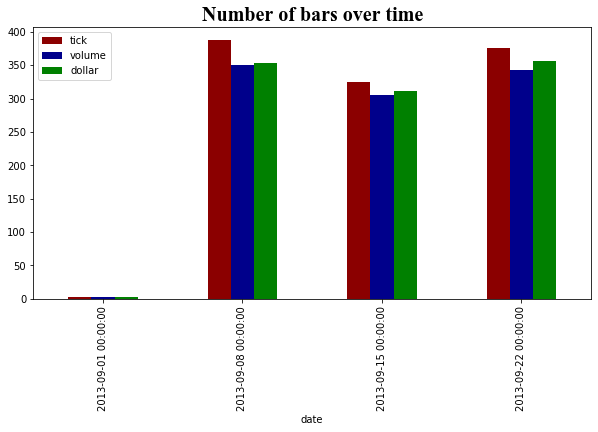

In [4]:
# Plot
count_df.plot(kind='bar', figsize=[10, 5], color=('darkred', 'darkblue', 'green', 'darkcyan'))
plt.title('Number of bars over time', loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.show()

In [5]:
n_ticks = tick_bars.shape[0]
volume_ratio = (tick_bars.volume.sum()/n_ticks).round()
dollar_ratio = ((tick_bars['volume']*tick_bars['close']).sum()/n_ticks).round()
print(f'num ticks: {n_ticks:,}')
print(f'volume ratio: {volume_ratio}')
print(f'dollar ratio: {dollar_ratio}')

num ticks: 1,091
volume ratio: 19919.0
dollar ratio: 33422494.0


In [6]:
def scale(s):
    return (s-s.min())/(s.max()-s.min())

In [7]:
# count series (scaled)
tc = scale(tick_count)
vc = scale(volume_count)
dc = scale(dollar_count)

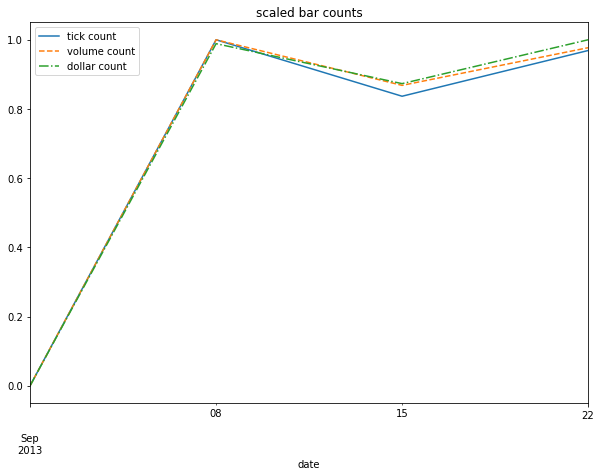

In [8]:
# plot time series of count

f,ax=plt.subplots(figsize=(10,7))

tc.plot(ax=ax, ls='-', label='tick count')
vc.plot(ax=ax, ls='--', label='volume count')
dc.plot(ax=ax, ls='-.', label='dollar count')

ax.set_title('scaled bar counts')
ax.legend()

In [9]:
# Stability via Standard Deviation
print(f'tc std: {tc.std():.2%}, vc std: {vc.std():.2%}, dc std: {dc.std():.2%}')

bar_types = ['tick','volume','dollar']
bar_std = [tc.std(),vc.std(),dc.std()]
counts = (pd.Series(bar_std,index=bar_types))
counts.sort_values()

tc std: 47.29%, vc std: 47.77%, dc std: 48.04%


tick      0.472940
volume    0.477685
dollar    0.480423
dtype: float64

We dont have enough data here to tell which is the most stable bar type. In the paper they use 2 years worth of tick data. We only have 20 days.

## Compute serial correlation of returns for the three bar types. What bar method has the lowest serial correlation?

In [11]:
tick_returns = np.log(tick_bars['close']).diff().dropna()
volume_returns = np.log(volume_bars['close']).diff().dropna()
dollar_returns = np.log(dollar_bars['close']).diff().dropna()

bar_returns = [tick_returns, volume_returns, dollar_returns]

In [12]:
def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

autocorrs = get_test_stats(bar_types,bar_returns,pd.Series.autocorr)
display(autocorrs.sort_values('autocorr_stat'),
        autocorrs.abs().sort_values('autocorr_stat'))

,sample_size,autocorr_stat
tick,1090.0,-0.002765
volume,1000.0,0.030824
dollar,1023.0,0.033194


,sample_size,autocorr_stat
tick,1090.0,0.002765
volume,1000.0,0.030824
dollar,1023.0,0.033194


In [25]:
def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(10,7))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=10, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,  
                                 title=f'{typ} AutoCorr')
    plt.tight_layout()   
    
def plot_hist(bar_types,bar_rets):
    f,axes=plt.subplots(len(bar_types),figsize=(10,6))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.distplot(bar, ax=axes[i], kde=False, label=typ)
        g.set(yscale='log')
        axes[i].legend()
    plt.tight_layout()

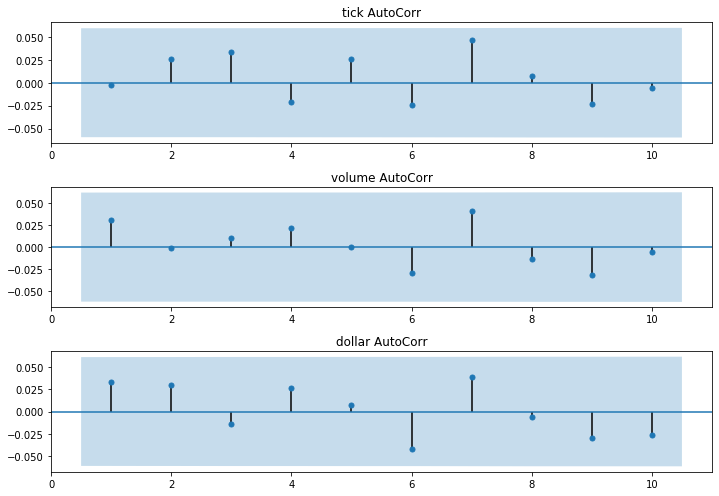

In [28]:
plot_autocorr(bar_types,bar_returns)

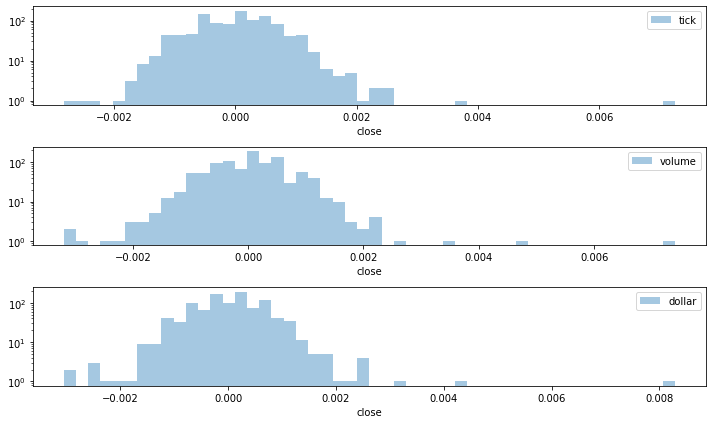

In [29]:
plot_hist(bar_types,bar_returns)

## Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?

In [36]:
def jb(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.jarque_bera(x)[0]
    return stats.jarque_bera(x)[1]

get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
tick,1090.0,4521.614457
volume,1000.0,4911.461089
dollar,1023.0,11916.740046


## Shapiro-Wilk Test

In [37]:
# Shapiro-Wilk test statistic > larger is better
def shapiro(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.shapiro(x)[0]
    return stats.shapiro(x)[1]

(get_test_stats(bar_types,bar_returns,shapiro)
 .sort_values('shapiro_stat')[::-1])

,sample_size,shapiro_stat
tick,1090.0,0.946281
volume,1000.0,0.931406
dollar,1023.0,0.912013


## Standardize & Plot the Distributions

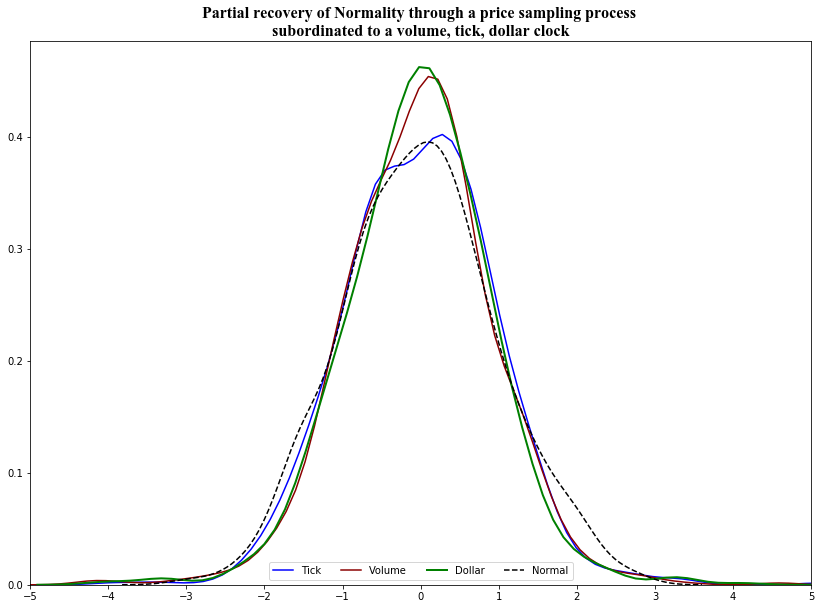

In [30]:
# Calculate the differences
tick_diff = tick_returns
volume_diff = volume_returns
dollar_diff = dollar_returns

# Standardize the data
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

# Plot the Distributions
plt.figure(figsize=(14,10))

sns.kdeplot(tick_standard, label="Tick", bw=0.25, color='blue')
sns.kdeplot(volume_standard, label="Volume", bw=0.25, color='darkred')
sns.kdeplot(dollar_standard, label="Dollar", bw=0.25, linewidth=2, color='green')

sns.kdeplot(np.random.normal(size=len(volume_returns)), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5)
plt.title('Partial recovery of Normality through a price sampling process \nsubordinated to a volume, tick, dollar clock',
          loc='center', fontsize=16, fontweight="bold", fontname="Times New Roman")
plt.xlim(-5, 5)
plt.show()